# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_mag"],
    "x_transforms_target": ["unit_mag"],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_mag']
x_transforms_target ['unit_mag']
Average magnitude, source: 1.0
Average power, source: 1.2938575


Average magnitude, target: 1.0
Average power, target: 1.2042067


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1978.5178, train_label_loss: 4.7025, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3964.2394, train_label_loss: 4.0768, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4047.7836, train_label_loss: 3.4847, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4050.9105, train_label_loss: 2.8169, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4048.1833, train_label_loss: 2.5928, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3963.7376, train_label_loss: 2.1721, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4042.0089, train_label_loss: 1.8203, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4049.2926, train_label_loss: 1.6662, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4086.7961, train_label_loss: 1.5885, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4152.0695, train_label_loss: 1.6678, 


epoch: 1, source_val_acc_label: 0.7808, target_val_acc_label: 0.7276, source_val_label_loss: 1.3151, target_val_label_loss: 1.5534, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 497.7390, train_label_loss: 1.3099, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4028.4005, train_label_loss: 1.1110, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4141.4873, train_label_loss: 1.1526, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4132.8066, train_label_loss: 1.1908, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4132.6308, train_label_loss: 1.3481, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4053.8572, train_label_loss: 1.0519, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4128.8741, train_label_loss: 0.9958, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4128.5958, train_label_loss: 1.0111, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4159.8096, train_label_loss: 0.9905, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4207.7023, train_label_loss: 0.9900, 


epoch: 2, source_val_acc_label: 0.8609, target_val_acc_label: 0.7880, source_val_label_loss: 0.7746, target_val_label_loss: 1.1014, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 489.5310, train_label_loss: 0.6481, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4033.8290, train_label_loss: 0.8359, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4134.9421, train_label_loss: 0.8395, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4132.4244, train_label_loss: 0.6954, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4133.0772, train_label_loss: 0.6102, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4058.9547, train_label_loss: 0.7566, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4135.6541, train_label_loss: 0.7629, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4126.6882, train_label_loss: 0.3970, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4170.7463, train_label_loss: 0.5016, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4220.2455, train_label_loss: 0.6287, 


epoch: 3, source_val_acc_label: 0.8955, target_val_acc_label: 0.8135, source_val_label_loss: 0.5674, target_val_label_loss: 0.9650, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 491.0459, train_label_loss: 0.7266, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4027.2862, train_label_loss: 0.5209, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4133.1258, train_label_loss: 0.6105, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4130.8303, train_label_loss: 0.6137, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4131.0043, train_label_loss: 0.4822, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4047.7710, train_label_loss: 0.6509, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4077.6975, train_label_loss: 0.4959, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4121.9822, train_label_loss: 0.4539, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4168.7005, train_label_loss: 0.3548, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4217.7808, train_label_loss: 0.3678, 


epoch: 4, source_val_acc_label: 0.9199, target_val_acc_label: 0.8378, source_val_label_loss: 0.4406, target_val_label_loss: 0.8609, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 490.1401, train_label_loss: 0.5394, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4022.9525, train_label_loss: 0.4529, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4120.3781, train_label_loss: 0.2970, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4125.8130, train_label_loss: 0.4049, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4115.1476, train_label_loss: 0.4660, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4041.7245, train_label_loss: 0.3402, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4119.4971, train_label_loss: 0.2671, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4123.1979, train_label_loss: 0.2731, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4161.5176, train_label_loss: 0.5802, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4218.6358, train_label_loss: 0.3112, 


epoch: 5, source_val_acc_label: 0.9474, target_val_acc_label: 0.8481, source_val_label_loss: 0.3440, target_val_label_loss: 0.7979, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 490.0970, train_label_loss: 0.3584, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4025.7341, train_label_loss: 0.2346, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4124.9072, train_label_loss: 0.2348, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4117.7207, train_label_loss: 0.2647, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4111.7775, train_label_loss: 0.3057, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4046.4228, train_label_loss: 0.3287, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4125.9044, train_label_loss: 0.3922, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4128.7537, train_label_loss: 0.4031, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4161.0705, train_label_loss: 0.3459, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4214.7390, train_label_loss: 0.2143, 


epoch: 6, source_val_acc_label: 0.9494, target_val_acc_label: 0.8547, source_val_label_loss: 0.3075, target_val_label_loss: 0.7539, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 489.4547, train_label_loss: 0.3009, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4028.5791, train_label_loss: 0.1216, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4117.4549, train_label_loss: 0.3198, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4127.2070, train_label_loss: 0.1346, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4129.7215, train_label_loss: 0.2942, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4055.5807, train_label_loss: 0.2101, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4129.1680, train_label_loss: 0.1886, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4124.0134, train_label_loss: 0.2296, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4167.1177, train_label_loss: 0.2171, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4215.5748, train_label_loss: 0.2761, 


epoch: 7, source_val_acc_label: 0.9526, target_val_acc_label: 0.8603, source_val_label_loss: 0.2717, target_val_label_loss: 0.7319, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 495.1857, train_label_loss: 0.1202, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4018.9954, train_label_loss: 0.1838, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4096.6463, train_label_loss: 0.3386, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4119.9347, train_label_loss: 0.1995, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4111.4364, train_label_loss: 0.2895, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4045.0876, train_label_loss: 0.3296, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4117.4440, train_label_loss: 0.2573, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4121.9947, train_label_loss: 0.1846, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4149.9076, train_label_loss: 0.2836, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4206.4039, train_label_loss: 0.1226, 


epoch: 8, source_val_acc_label: 0.9564, target_val_acc_label: 0.8650, source_val_label_loss: 0.2584, target_val_label_loss: 0.7230, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 486.6672, train_label_loss: 0.1950, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4026.7524, train_label_loss: 0.1387, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4120.9511, train_label_loss: 0.3307, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4119.0409, train_label_loss: 0.1454, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4125.0835, train_label_loss: 0.1882, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4047.4585, train_label_loss: 0.1780, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4123.3132, train_label_loss: 0.2828, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4099.7943, train_label_loss: 0.2356, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4147.5124, train_label_loss: 0.2606, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4208.2885, train_label_loss: 0.1344, 


epoch: 9, source_val_acc_label: 0.9590, target_val_acc_label: 0.8673, source_val_label_loss: 0.2516, target_val_label_loss: 0.6982, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 486.3950, train_label_loss: 0.1380, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4004.4588, train_label_loss: 0.2244, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4112.7808, train_label_loss: 0.1131, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4108.4017, train_label_loss: 0.1260, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4114.6383, train_label_loss: 0.2595, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4032.9250, train_label_loss: 0.1160, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4108.8432, train_label_loss: 0.1347, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4108.4980, train_label_loss: 0.1700, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4159.0887, train_label_loss: 0.1014, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4210.8380, train_label_loss: 0.2012, 


epoch: 10, source_val_acc_label: 0.9603, target_val_acc_label: 0.8754, source_val_label_loss: 0.2350, target_val_label_loss: 0.6830, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 484.7810, train_label_loss: 0.3150, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4018.9199, train_label_loss: 0.1486, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4112.7234, train_label_loss: 0.1727, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4116.9559, train_label_loss: 0.1281, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4119.9329, train_label_loss: 0.2475, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4042.1033, train_label_loss: 0.1424, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4114.5793, train_label_loss: 0.2182, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4117.1207, train_label_loss: 0.1427, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4143.7578, train_label_loss: 0.1937, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4208.7270, train_label_loss: 0.1668, 


epoch: 11, source_val_acc_label: 0.9615, target_val_acc_label: 0.8705, source_val_label_loss: 0.2186, target_val_label_loss: 0.6717, 


epoch: 12, [batch: 1 / 45], examples_per_second: 504.8976, train_label_loss: 0.1085, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4012.9924, train_label_loss: 0.1447, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4109.3913, train_label_loss: 0.1671, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4119.4106, train_label_loss: 0.1569, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4106.5780, train_label_loss: 0.1268, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4029.6000, train_label_loss: 0.1120, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4112.6288, train_label_loss: 0.1058, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4132.8000, train_label_loss: 0.0561, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4154.5507, train_label_loss: 0.0872, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4207.8176, train_label_loss: 0.1936, 


epoch: 12, source_val_acc_label: 0.9635, target_val_acc_label: 0.8705, source_val_label_loss: 0.2208, target_val_label_loss: 0.6755, 


epoch: 13, [batch: 1 / 45], examples_per_second: 503.1313, train_label_loss: 0.1111, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4009.3865, train_label_loss: 0.1257, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4113.8016, train_label_loss: 0.1297, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4102.7619, train_label_loss: 0.1704, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4111.8100, train_label_loss: 0.2411, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4045.0071, train_label_loss: 0.1185, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4101.4935, train_label_loss: 0.1163, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4107.3514, train_label_loss: 0.0818, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4151.0172, train_label_loss: 0.0454, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4204.0947, train_label_loss: 0.2461, 


epoch: 13, source_val_acc_label: 0.9628, target_val_acc_label: 0.8735, source_val_label_loss: 0.2155, target_val_label_loss: 0.6512, 


epoch: 14, [batch: 1 / 45], examples_per_second: 502.0366, train_label_loss: 0.1408, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4001.7961, train_label_loss: 0.1205, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4110.8118, train_label_loss: 0.1212, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4116.8154, train_label_loss: 0.1072, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4111.0381, train_label_loss: 0.1195, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4039.2083, train_label_loss: 0.1349, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4124.1116, train_label_loss: 0.1486, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4117.3492, train_label_loss: 0.1781, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4151.8162, train_label_loss: 0.1183, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4200.9949, train_label_loss: 0.0383, 


epoch: 14, source_val_acc_label: 0.9647, target_val_acc_label: 0.8769, source_val_label_loss: 0.2147, target_val_label_loss: 0.6647, 


New best


epoch: 15, [batch: 1 / 45], examples_per_second: 486.6654, train_label_loss: 0.1254, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4016.2172, train_label_loss: 0.2213, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4110.5407, train_label_loss: 0.0942, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4116.9559, train_label_loss: 0.1010, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4111.6333, train_label_loss: 0.0749, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4031.5283, train_label_loss: 0.1709, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4108.3355, train_label_loss: 0.0883, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4116.4198, train_label_loss: 0.0666, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4146.7579, train_label_loss: 0.0721, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4211.6349, train_label_loss: 0.0914, 


epoch: 15, source_val_acc_label: 0.9654, target_val_acc_label: 0.8803, source_val_label_loss: 0.2021, target_val_label_loss: 0.6543, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 487.2121, train_label_loss: 0.0839, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4023.5195, train_label_loss: 0.0713, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4120.1928, train_label_loss: 0.1742, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4118.9289, train_label_loss: 0.0859, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4116.7259, train_label_loss: 0.1438, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4028.2901, train_label_loss: 0.1579, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4108.2705, train_label_loss: 0.1199, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4119.5142, train_label_loss: 0.0937, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4147.2626, train_label_loss: 0.0515, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4206.5418, train_label_loss: 0.0575, 


epoch: 16, source_val_acc_label: 0.9660, target_val_acc_label: 0.8786, source_val_label_loss: 0.1989, target_val_label_loss: 0.6603, 


epoch: 17, [batch: 1 / 45], examples_per_second: 502.3952, train_label_loss: 0.0628, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4003.3312, train_label_loss: 0.1763, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4117.4533, train_label_loss: 0.1084, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4109.3393, train_label_loss: 0.1508, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4114.2440, train_label_loss: 0.1793, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4037.5215, train_label_loss: 0.0484, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4117.3865, train_label_loss: 0.0273, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4112.3775, train_label_loss: 0.0478, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4146.7554, train_label_loss: 0.1312, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4200.6955, train_label_loss: 0.0724, 


epoch: 17, source_val_acc_label: 0.9667, target_val_acc_label: 0.8754, source_val_label_loss: 0.1988, target_val_label_loss: 0.6667, 


epoch: 18, [batch: 1 / 45], examples_per_second: 503.9026, train_label_loss: 0.1979, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4016.3193, train_label_loss: 0.0687, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4113.3563, train_label_loss: 0.0335, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4118.0255, train_label_loss: 0.1083, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4109.7584, train_label_loss: 0.0440, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4046.0241, train_label_loss: 0.1408, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4116.9994, train_label_loss: 0.1168, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4122.3609, train_label_loss: 0.1055, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4153.4418, train_label_loss: 0.1184, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4212.9056, train_label_loss: 0.0874, 


epoch: 18, source_val_acc_label: 0.9673, target_val_acc_label: 0.8793, source_val_label_loss: 0.2121, target_val_label_loss: 0.6529, 


epoch: 19, [batch: 1 / 45], examples_per_second: 507.9368, train_label_loss: 0.0478, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4010.6339, train_label_loss: 0.0552, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4088.0156, train_label_loss: 0.0740, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4115.6110, train_label_loss: 0.0633, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4104.9750, train_label_loss: 0.0634, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4027.7212, train_label_loss: 0.0197, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4112.8645, train_label_loss: 0.1267, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4106.0801, train_label_loss: 0.0300, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4140.7998, train_label_loss: 0.1651, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4202.2479, train_label_loss: 0.0551, 


epoch: 19, source_val_acc_label: 0.9654, target_val_acc_label: 0.8756, source_val_label_loss: 0.2087, target_val_label_loss: 0.6648, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

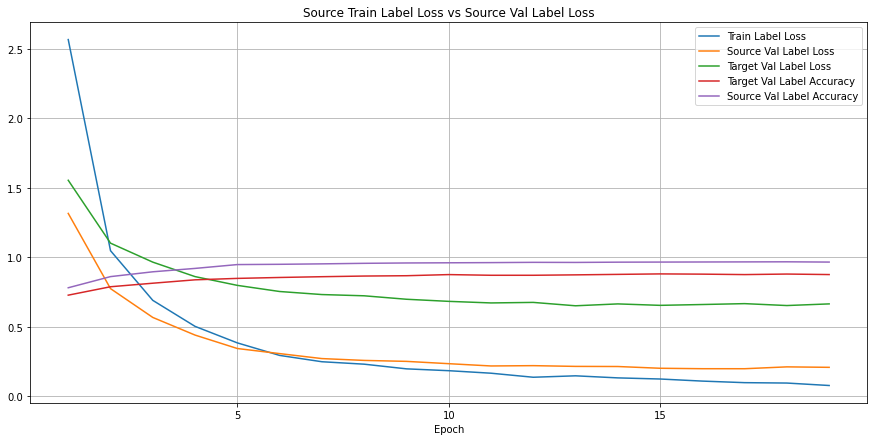

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

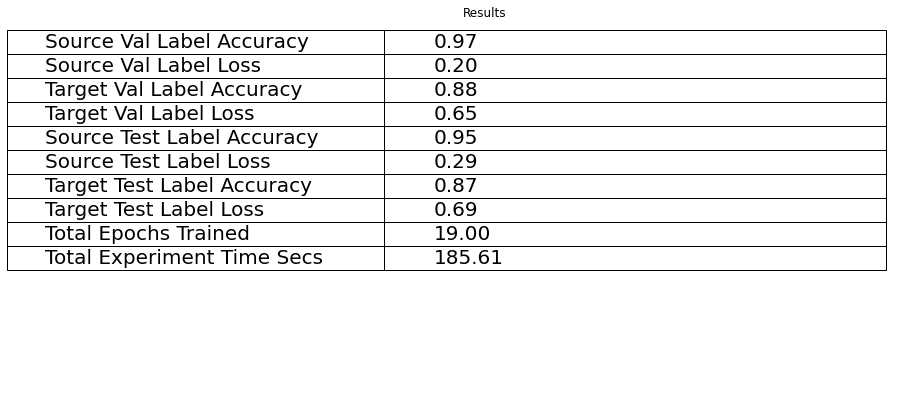

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

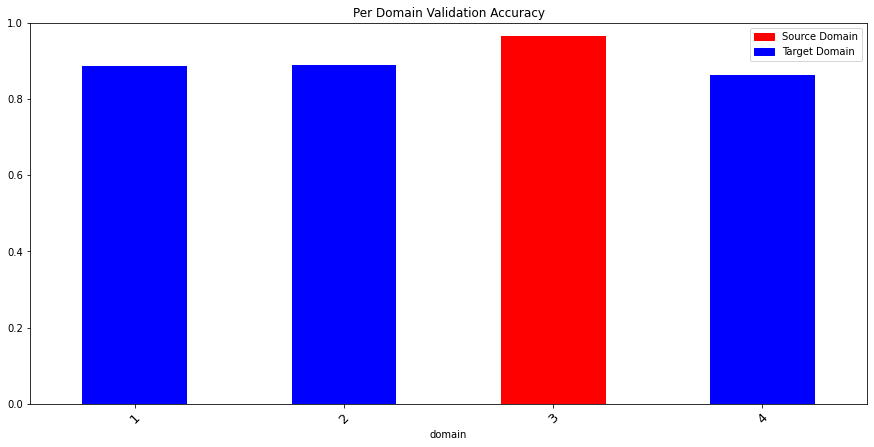

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9544871794871795 Target Test Label Accuracy: 0.8722222222222222
Source Val Label Accuracy: 0.9653846153846154 Target Val Label Accuracy: 0.8803418803418803


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "